In [1]:
__version__ = '20180808' #Revised version
#__version__ = '20180806' #Launched version

## Imports and setup
We import all modules required for this notebook

In [1]:
# std. lib
import sys
sys.path.append('../../../hypercat/hypercat/')

# 3rd party
import pylab as plt
import numpy as np

# hypercat
import hypercat
import plotting
import ioops
import psf
import obsmodes
import imageops

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
###----------------HDF file dir-------------------###
#hdffile = '/YOUR_HDF_FILEPATH/hypercat_20180417.hdf5'  #For the public version
#hdffile = '/Volumes/Kohei_HDD_201803/hypercat/hypercat_20180417.hdf5' #Kohei's local dir
hdffile = '/Volumes/Seagate Backup Plus Drive/hypercat/hypercat_20180417.hdf5'

# Imaging 'Observation'
In this notebook we will describe how to obtain the 'observed' image based on the actual set of telescope/insrument

In [5]:
imgcube = hypercat.ModelCube(hdffile, hypercube='imgdata', subcube_selection='minimal')

Opening HDF5 file: /Volumes/Seagate Backup Plus Drive/hypercat/hypercat_20180417.hdf5 
Loading sampling parameters.
Closing HDF5 file.
Loading  hypercube 'imgdata' [shape: (5,10,16,12,5,7,19,121,241)] to RAM (693.51 GB required) ...
Inspect the loaded hypercube with .print_sampling()

-------------------------------------------------------
Parameter  Range                Nvalues  Sampled values
-------------------------------------------------------
 sig*    [ 15.000 -  75.000]  (  5)    15.000, 30.000, 45.000, 60.000, 75.000
   i*    [  0.000 -  90.000]  ( 10)     0.000, 10.000, 20.000, 30.000, 40.000, 50.000, 60.000, 70.000, 80.000, 90.000
   Y*    [  5.000 -  20.000]  ( 16)     5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, 12.000, 13.000, 14.000, 15.000, ...
   N*    [  1.000 -  12.000]  ( 12)     1.000,  2.000,  3.000,  4.000,  5.000,  6.000,  7.000,  8.000,  9.000, 10.000, 11.000, ...
   q*    [  0.000 -   2.000]  (  5)     0.000,  0.500,  1.000,  1.500,  2.000
  tv*    [

In [10]:
#sig, i, Y, N, q, tv, wave = 15, 90, 18, 4, 0.01, 90, 2.2  # example parameters, here e.g. for NGC1068 from Lopez-Rodriguez+2018
sig, i, Y, N, q, tv, wave = 43, 55, 18, 4, 0.08, 70, 2.2
vec = (sig, i, Y, N, q, tv, wave) #The order of the parameter set is also important...
#list of the parameters
Lbol = '1.6e45 erg/s' #the unit Lsun is also available. Is is used only for calculating dust sublimation radius
D = '14.4 Mpc'
PA = '42 deg' #PA is optional
objectname = 'ngc1068' #objectname is optional

Loading a subcube of 14.2388 MB into RAM.
Squeezing all dim-1 axes...
Instantiating n-dim interpolation object ...
Done.
Rotated image (see self.data) by 42.0 deg in direction 'NE'.
Coordinates for source 'ngc1068' resolved. WCS created.
Plotting panel (0,0)


(<matplotlib.figure.Figure at 0x109aa2978>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0xae6f424da0>]],
       dtype=object))

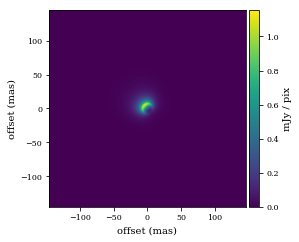

In [14]:
ngc1068 = hypercat.Source(imgcube,luminosity=Lbol,distance=D,pa=PA,objectname=objectname)
sky = ngc1068(vec,total_flux_density='314 mJy')
plotting.multiplot(sky)

# Imaging

Let's get the Pupil and PSF from a telescope

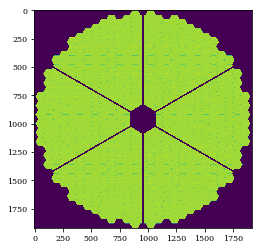

In [5]:
### - Pupil Mode
psfdict = {'psfmode':'pupil',\
           'telescope':'TMT',\
           'wavelength':'10 micron',\
           'pixelscale_detector':'Nyquist'}
Pupil, Pupilheader = psf.getPupil(psfdict)
plt.imshow(Pupil)

Pixel scale in PSF image is:  68.82662982176304  mas per pixel


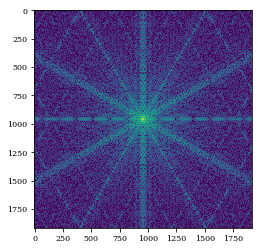

In [6]:
# get PSF
psfdict = {'psfmode':'pupil',\
           'telescope':'TMT',\
           'wavelength':'10 micron',\
           'pixelscale_detector':'Nyquist'}
PSF = psf.getPSF(psfdict)
plt.imshow(np.log10(PSF.I),vmin=-6,vmax=-1)

## NOTE: Plot the PSF in arcsecs. PSF has the pixelscale, FOV information.

In [15]:
#Synthetic obervations
psfdict = {'psfmode':'pupil',\
           'telescope':'TMT',\
           'wavelength':'2.2 micron',\
           'pixelscale_detector':'Nyquist'}
#Create the Instrument for the observations
obs = obsmodes.Imaging(psfdict)
#perform the observations
ngc1068_obs, PSF, PSF_resampled = obs.observe(sky,psfdict=psfdict)
#deconvolve observations
ngc1068_deconv = PSF_resampled.deconvolve(ngc1068_obs)

Pixel scale in PSF image is:  15.141858560787872  mas per pixel
Pixel scale in PSF image is:  15.141858560787872  mas per pixel
self.PSF: Computed pixelscale from pupil =  15.141858560787872 mas  [mas/px]
[WARNING]: The requested resampling to pixel scale (1.2079 mas) was slightly adjusted due to discretization (now 1.20506 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (7.57093 mas) was slightly adjusted due to discretization (now 7.46421 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (7.57093 mas) was slightly adjusted due to discretization (now 7.44666 mas). This is to preserve sizes on the sky.
Coordinates for source 'ngc1068' resolved. WCS created.


Text(0.5,1,'Deconvolved observations')

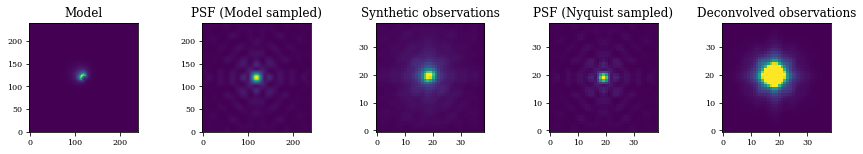

In [16]:
fig, axs = plt.subplots(1,5,figsize=(15,2))
ax = axs.flatten()

ax[0].imshow(sky.I,origin='lower')
ax[1].imshow(PSF.I,origin='lower')
ax[2].imshow(ngc1068_obs.I,origin='lower')
ax[3].imshow(PSF_resampled.I,origin='lower')
ax[4].imshow(ngc1068_deconv,origin='lower')

#titles
ax[0].set_title('Model')
ax[1].set_title('PSF (Model sampled)')
ax[2].set_title('Synthetic observations')
ax[3].set_title('PSF (Nyquist sampled)')
ax[4].set_title('Deconvolved observations')

(array([20]), array([19]))


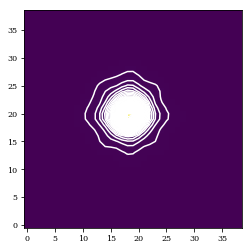

In [54]:
from skimage import restoration
ima = ngc1068_obs.I/np.sum(ngc1068_obs.I)
psf = PSF_resampled.I/np.sum(PSF_resampled.I)
result = restoration.richardson_lucy(ima, psf, iterations=10)
plt.imshow(result,origin='lower')
print(np.where(result == result.max()))

Pixel scale in PSF image is:  17.087396530997434  mas per pixel
Pixel scale in PSF image is:  17.087396530997434  mas per pixel
self.PSF: Computed pixelscale from pupil =  17.087396530997434 mas  [mas/px]
[WARNING]: The requested resampling to pixel scale (1.2079 mas) was slightly adjusted due to discretization (now 1.2082 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (38.835 mas) was slightly adjusted due to discretization (now 41.5863 mas). This is to preserve sizes on the sky.
[WARNING]: The requested resampling to pixel scale (38.835 mas) was slightly adjusted due to discretization (now 41.5966 mas). This is to preserve sizes on the sky.
Coordinates for source 'ngc1068' resolved. WCS created.


Text(0.5,1,'Deconvolved SNR=10')

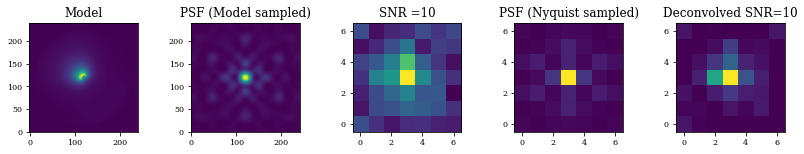

In [31]:
#Synthetic obervations
psfdict = {'psfmode':'pupil',\
           'telescope':'GMT',\
           'wavelength':'2.2 micron',\
           'pixelscale_detector':'Nyquist'}
#Create the Instrument for the observations
obs = obsmodes.Imaging(psfdict)
#perform the observations with a level of noise
SNR = 10
ngc1068_noisy, PSF, PSF_resampled = obs.observe(sky,snr=SNR,psfdict=psfdict)
#deconvolve observations
ngc1068_deconv_noisy = PSF_resampled.deconvolve(ngc1068_noisy)

#Plotting
fig, axs = plt.subplots(1,5,figsize=(14,2))
ax = axs.flatten()

ax[0].imshow(sky.I,origin='lower')
ax[1].imshow(PSF.I,origin='lower')
ax[2].imshow(ngc1068_noisy.I,origin='lower')
ax[3].imshow(PSF_resampled.I,origin='lower')
ax[4].imshow(ngc1068_deconv_noisy,origin='lower')

#titles
ax[0].set_title('Model')
ax[1].set_title('PSF (Model sampled)')
ax[2].set_title('SNR ='+np.str(SNR))
ax[3].set_title('PSF (Nyquist sampled)')
ax[4].set_title('Deconvolved SNR=10')

In [ ]:
idxpeak1d = np.argmax(PSF.I)
idx2d = np.unravel_index(idxpeak1d,PSF.I.shape)
psf_radialprofile = imageops.radial_profile(PSF.I,idx2d)

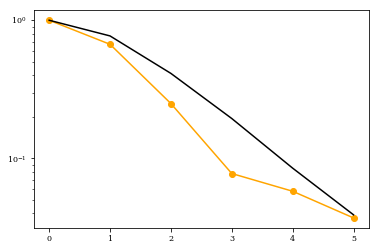

In [12]:
idxpeak1d = np.argmax(PSF_resampled.I)
idx2d = np.unravel_index(idxpeak1d,PSF_resampled.I.shape)
psf_radialprofile = imageops.radial_profile(PSF_resampled.I,idx2d)
ima_radialprofile = imageops.radial_profile(ngc1068_obs.I,idx2d)


plt.plot(psf_radialprofile/psf_radialprofile.max(),'o-',color='orange')
plt.plot(ima_radialprofile/ima_radialprofile.max(),'-',color='black')

plt.yscale('log')